###***Topic : Uncertainity-aware Deep Learning***

# **Question 1**

**What is the problem that the paper aims to solve, and why is this problem important or interesting? Answer this question in two sentences.**

## **Answer:**
The paper aims to handle the problem of uncertainty in safety-sensitive AI applications such as object recognition in autonomous driving, hence it is crucial to study the principled approaches in order to obtain high quality uncertainty estimation using DNN. Paper uses techniques such as Spectral-normalised Neural Gaussian Process (SNGP), a straightforward technique that increases the capacity of DNNs for distance awareness by including a weight normalisation step during training and substituting a Gaussian Process for the output layer for obtaining high quality uncertainty estimation.
The problem is significant because enhancing the uncertainty estimation performance of a Deterministic Deep Learning model will allow us to make meaningful improvements to AI-driven, socially relevant services where uncertainty is inherent.

# **Question 2**

**What is the meaning of “distance awareness”? How do the authors achieve “distance awareness”? Answer this question in two sentences.**

## **Answer:**
**Distance Awareness:-**
                  The degree to which a model's predicted probability reflects the separation between the input test example and the training set is known as "distance awareness.

---


Gold-standard probabilistic models like the Gaussian process share this desirable attribute (i.e. Distance Awareness). To do this, the authors have introduced a weight normalisation step and have replaced the output layer with a Gaussian Process.

# **Question 3**
**Design and implement a toy experiment to showcase the effect of “spectral normalization”**


In [ ]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 727 kB 15.0 MB/s 


In [ ]:
import os
import sys
import time
import copy


import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sklearn.datasets
import sklearn.gaussian_process

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.infer as infer


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

XRANGE = (-3.5, 3.5)
YRANGE = (-2.5, 2.5)
CMAP = colors.ListedColormap(["#28119c", "#bd0924"])
DEFAULT_NORM = colors.Normalize(vmin=0, vmax=1,)
DEFAULT_N_GRID = 200


In [ ]:
def make_ood_data(sample_size=500, means=(2.5, -1.75), vars=(0.01, 0.01)):
    return np.random.multivariate_normal(means, cov=np.diag(vars), size=sample_size)

def generate_test_data(x_range=XRANGE, y_range=YRANGE, n_grid=DEFAULT_N_GRID):
    """Create a mesh grid in 2D space."""
    # testing data (mesh grid over data space)
    x = np.linspace(x_range[0], x_range[1], n_grid)
    y = np.linspace(y_range[0], y_range[1], n_grid)
    xv, yv = np.meshgrid(x, y)
    return np.stack([xv.flatten(), yv.flatten()], axis=-1)

def generate_train_data(sample_size=500):
    x_train, y_train = sklearn.datasets.make_moons(
        n_samples=2 * sample_size, noise=0.1)

    # Adjust data position slightly.
    x_train[y_train == 0] += [-0.1, 0.2]
    x_train[y_train == 1] += [0.1, -0.2]

    return x_train, y_train

x_train, y_train = generate_train_data(sample_size=500)
x_test = generate_test_data()
ood_examples = make_ood_data(sample_size=500)

In [ ]:

def plot_uncertainty_surface(test_uncertainty, cmap=None):
    """Visualizes the 2D uncertainty surface.
    """
    # Visualization improvement by normalizing the uncertainty.
    test_uncertainty = (test_uncertainty / np.max(test_uncertainty)).reshape([DEFAULT_N_GRID, DEFAULT_N_GRID])

    # Set boundaries for views.
    plt.ylim(YRANGE)
    plt.xlim(XRANGE)

    # Plotting of uncertainty surface normalization.
    plt.imshow(
        test_uncertainty,
        cmap=cmap,
        origin="lower",
        extent=XRANGE + YRANGE,
        vmin=DEFAULT_NORM.vmin,
        vmax=DEFAULT_NORM.vmax,
        interpolation='bicubic',
        aspect='auto'
    )

    # Plot all the training data.
    plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=CMAP, alpha=0.5)
    plt.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

# helper function for training and validation model
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, run_validation=True):
    """
    this function train the models while returning the norm of the weights of the last layer of the classification model
    """

    val_acc_history = []
    weight_history = []


    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        # to watch the spectral normalization layer effect
        if not model.with_gaussian_process:
            weights = model.classifier.weight.detach().cpu().numpy()
            # store the norm of the weights for visualization
            weight_norm = np.linalg.norm(weights)
            weight_history.append(weight_norm)

        # Each epoch has a training and validation phase
        # However, for question 3, we don't need to do validation.
        phases = ["train", "val"] if run_validation else ["train"]
        for phase in phases:

            model.train() if phase == "train" else model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    mean_loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        mean_loss.backward()
                        optimizer.step()

                # stats
                running_loss += mean_loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if run_validation:
                print('{} Loss: {:.3f} Acc: {:.3f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, val_acc_history, weight_history

def generate_train_data_loader(sample_size=500):
    """ Two moons dataset """

    dataset = torch.utils.data.TensorDataset(
        torch.Tensor(x_train),
        torch.Tensor(y_train).long()
    )

    return {
        "train": torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
    }

class CustomResNet(torch.nn.Module):
    def __init__(self,
        num_classes, num_layers=3, num_hidden=128,
        dropout_rate=0.01,
        with_spectral_normalization=False,
        with_gaussian_process=False,
        **classifier_kwargs
    ):
        super().__init__()
        # Defines class data.
        self.num_hidden = num_hidden
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.classifier_kwargs = classifier_kwargs
        self.with_spectral_normalization = with_spectral_normalization
        self.with_gaussian_process = with_gaussian_process

        input_layer = torch.nn.Linear(in_features=2, out_features=self.num_hidden)
        dense_layers = [torch.nn.Linear(in_features=self.num_hidden, out_features=self.num_hidden) for _ in range(num_layers)]
        classifier = None

        # output layer can be a linear layer or a gaussian process
        if not with_gaussian_process:
            classifier = torch.nn.Linear(in_features=num_hidden, out_features=num_classes)

        # we have to use torch.nn.ParameterList to put the layers in a python list
        if with_spectral_normalization:
            self.input_layer = torch.nn.utils.spectral_norm(input_layer, n_power_iterations=1)
            self.dense_layers = torch.nn.ParameterList([torch.nn.utils.spectral_norm(layer,n_power_iterations = 1) for layer in dense_layers])

            self.classifier = torch.nn.utils.spectral_norm(classifier, n_power_iterations=1) if classifier is not None else None

        else:
            self.input_layer = input_layer
            self.dense_layers = torch.nn.ParameterList(dense_layers)
            self.classifier = classifier if classifier is not None else None


    def to(self, *args, **kwargs):
        self = super().to(*args, **kwargs)
        self.input_layer = self.input_layer.to(*args, **kwargs)
        self.dense_layers = self.dense_layers.to(*args, **kwargs)

        if self.classifier is not None:
            self.classifier = self.classifier.to(*args, **kwargs)
        return self

    def forward(self, inputs):
        # Projects the 2d input data to high dimension.
        hidden = self.input_layer(inputs)

        # Computes the ResNet hidden representations.
        for i in range(self.num_layers):
            resid = torch.nn.ReLU()(self.dense_layers[i](hidden))
            resid = torch.nn.Dropout(p=self.dropout_rate)(resid)
            hidden = hidden +  resid


        return self.classifier(hidden) if self.classifier is not None else hidden


train Loss: 0.0006 Acc: 1.0000
Best val Acc: 0.000000
train Loss: 0.0804 Acc: 0.9640
Best val Acc: 0.000000


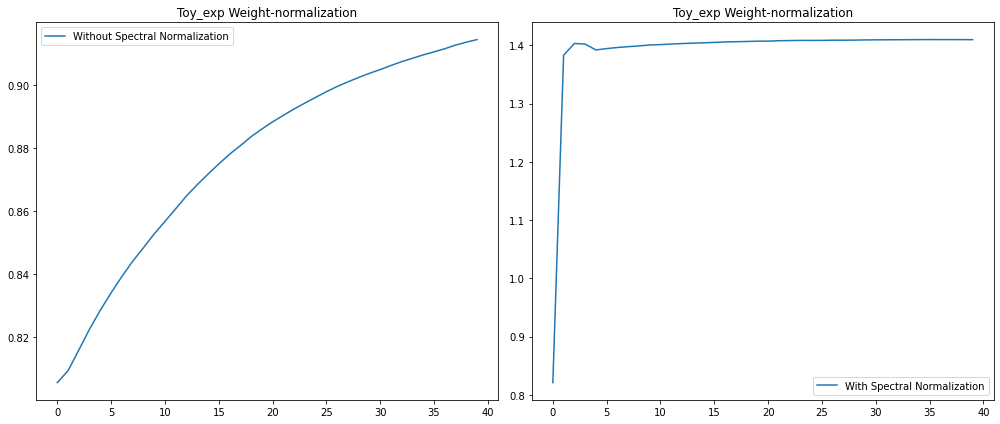

In [ ]:

def question_3():

    # Creating the models, one with spectral normalization and other without spectral normalization
    model_a = CustomResNet(num_classes=2, num_layers=4, with_spectral_normalization=False).to(device)

    model_b = CustomResNet(num_classes=2, num_layers=4, with_spectral_normalization=True).to(device)

    # create the dataloader
    data_loaders = generate_train_data_loader()

    # define the loss function
    crit_a = torch.nn.CrossEntropyLoss()
    crit_b = torch.nn.CrossEntropyLoss()

    # define optimizer
    opt_a = torch.optim.Adam(model_a.parameters(), lr=0.0001)
    opt_b = torch.optim.Adam(model_b.parameters(), lr=0.0001)


    # Train and evaluate
    model_ft, _, weight_history_a = train_model(model_a, data_loaders, crit_a, opt_a, num_epochs=40, run_validation=False)
    # Train and evaluate
    model_ft2, _, weight_history_b = train_model(model_b, data_loaders, crit_b, opt_b, num_epochs=40, run_validation=False)

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.title("Toy_exp Weight-normalization")
    plt.plot(weight_history_a, label="Without Spectral Normalization")
    plt.legend()
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.title("Toy_exp Weight-normalization")
    plt.plot(weight_history_b, label="With Spectral Normalization")
    plt.legend()
    plt.tight_layout()
    plt.show()

question_3()


We can see from this that in the model with Spectral Normalization applied to the weight, the weight normalization is preserved at reasonably stable values.  However, given the same training arrangement, the model will perform poorly (since the weights cannot be altered as freely as before).

# **Question 4**
**Reproduce the toy experiment (Figure 1 (f),(i),(j)) in the paper. You need to output the three figures.**

In [ ]:
def question_4_gp(x, y):
    """ train a gaussian process classifier with sk learn """
    classifier = sklearn.gaussian_process.GaussianProcessClassifier(
        kernel=sklearn.gaussian_process.kernels.RBF(1.0)
    )
    classifier.fit(x, y)

    return classifier.predict_proba(x_test)[:, 0]


def question_4_dnn_gp(train_loader, with_spectral_normalization=False, num_data=1000,lr=1e-3):
    pyro.clear_param_store()
    resnet = CustomResNet(
        num_classes=2, num_layers=8, with_spectral_normalization=with_spectral_normalization,
        with_gaussian_process=True
    )

    deep_kernel = gp.kernels.Warping(
        gp.kernels.RBF(input_dim=resnet.num_hidden, lengthscale=torch.ones(resnet.num_hidden)),
        iwarping_fn=resnet
    )
    latent_shape = torch.Size([2])

    likelihood = gp.likelihoods.MultiClass(num_classes=2)
    latent_shape = torch.Size([resnet.num_classes])

    # init inducing points (taken randomly from dataset)
    Xu = torch.Tensor(x_train)[:120].clone()

    gpmodule = gp.models.VariationalSparseGP(
        X=Xu,
        y=None,
        kernel=deep_kernel,
        Xu=Xu,
        likelihood=likelihood,
        latent_shape=latent_shape,
        num_data=num_data,
        whiten=True,
        jitter=1e-5,
    )

    optimizer = torch.optim.Adam(gpmodule.parameters(), lr=lr)

    elbo = infer.TraceMeanField_ELBO()
    loss_fn = elbo.differentiable_loss

    for epoch in range(1, 60+ 1):
        start_time = time.time()
        train_gp(train_loader, gpmodule, optimizer, loss_fn, epoch=epoch)

    f_loc, f_var = gpmodule(torch.Tensor(x_test))
    f_loc = f_loc.T / torch.sqrt(1. + (torch.pi / 8.) * f_var.T)
    probs = torch.nn.functional.softmax(f_loc, dim=-1)[:, 0].detach().numpy( )
    return probs

def train_gp(train_loader, gpmodule, optimizer, loss_fn, epoch):
    """ General function to train a gaussian process classifier """
    for batch_idx, (data, target) in enumerate(train_loader):

        gpmodule.set_data(data, target)
        optimizer.zero_grad()
        loss = loss_fn(gpmodule.model, gpmodule.guide)
        loss.backward()
        optimizer.step()
        batch_idx = batch_idx + 1
    print(f"\r{epoch}, {loss}", end="", flush=True)


60, 57.89656066894531

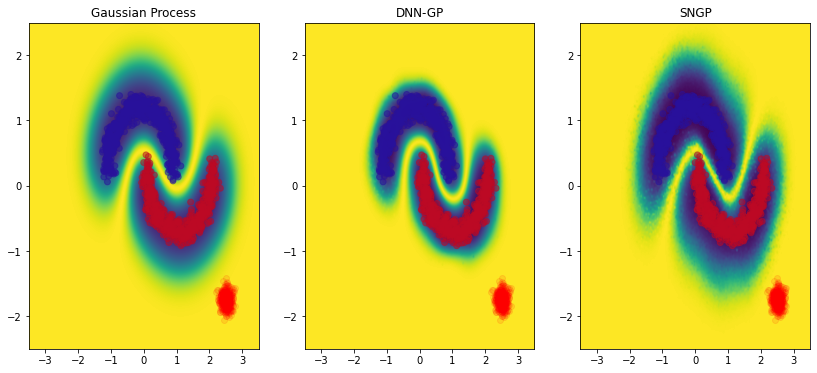

In [ ]:
prob_gp = question_4_gp(x_train, y_train)

while True:
    try:
        prob_dnn_gp = question_4_dnn_gp(generate_train_data_loader()["train"], with_spectral_normalization=False)
        break
    except:
        continue

while True:
    try:
        prob_dnn_sngp = question_4_dnn_gp(generate_train_data_loader()["train"], with_spectral_normalization=True)
        break
    except:
        continue

plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.title("Gaussian Process")
plot_uncertainty_surface(prob_gp*(1 - prob_gp))

plt.subplot(1, 3, 2)
plt.title("DNN-GP")
plot_uncertainty_surface(prob_dnn_gp*(1 - prob_dnn_gp))

plt.subplot(1, 3, 3)
plt.title("SNGP")
plot_uncertainty_surface(prob_dnn_sngp*(1 - prob_dnn_sngp))
plt.show()


# **Question 5**
**Conduct the same sets of experiments as Problem 4 on the mixture of 8 Gaussians and 25 Gaussians respectively. These Gaussians can be either identical or with different parameters at your choice. You need to output six pictures.**



60, 242.22393798828125

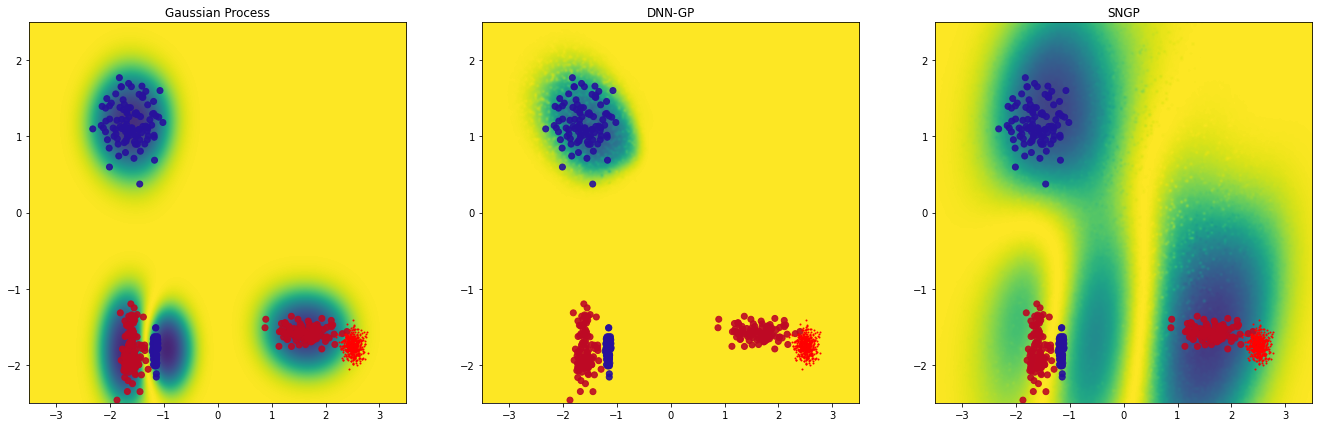

In [ ]:
def plot_result(samples, labels, test_uncertainty, cmap=None):
    """Visualizes the 2D uncertainty surface.
    """
   # Set view limits.
    plt.ylim(YRANGE)
    plt.xlim(XRANGE)

    # Plot normalized uncertainty surface.
    if test_uncertainty is not None:
            # Normalize uncertainty for better visualization.
        test_uncertainty = (
            test_uncertainty / np.max(test_uncertainty)
        ).reshape([DEFAULT_N_GRID, DEFAULT_N_GRID])


        plt.imshow(
            test_uncertainty,
            cmap=cmap,
            origin="lower",
            extent=XRANGE + YRANGE,
            vmin=DEFAULT_NORM.vmin,
            vmax=DEFAULT_NORM.vmax,
            interpolation='bicubic',
            aspect='auto'
        )

    # Plot training data.
    plt.scatter(samples[:, 0], samples[:, 1], c=labels, cmap=CMAP, alpha=0.9)
    plt.scatter(ood_examples[:, 0], ood_examples[:, 1],c='r', s=1)

def generate_4_gaussian():

    # generate 4 gaussians, 2 has labels 0, 2 has labels 1
    examples, labels = [], []
    size = 100
    for label in [0, 0, 1, 1]:
        pts = np.random.multivariate_normal(
            np.random.rand(2)*4 - 2,
            np.diag(np.random.rand(2)*0.12),
            size=size
        )
        examples.append(pts)
        labels.extend([label]*size)

    # generate data
    examples = np.concatenate(examples)
    labels = np.array(labels)

    # shuffle
    mask = np.arange(len(labels))
    np.random.shuffle(mask)
    examples = examples[mask]
    labels = labels[mask]

    dataset = torch.utils.data.TensorDataset(
        torch.Tensor(examples),
        torch.Tensor(labels).long()
    )

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


    prob_gp = question_4_gp(examples, labels)
    prob_dnn_gp = question_4_dnn_gp(data_loader, with_spectral_normalization=False)
    prob_dnn_sngp = question_4_dnn_gp(data_loader, with_spectral_normalization=True)


    plt.figure(figsize=(23, 7))
    plt.subplot(1, 3, 1)
    plt.title("Gaussian Process")
    plot_result(examples, labels, prob_gp*(1 - prob_gp))

    plt.subplot(1, 3, 2)
    plt.title("DNN-GP")
    plot_result(examples, labels, prob_dnn_gp*(1 - prob_dnn_gp))

    plt.subplot(1, 3, 3)
    plt.title("SNGP")
    plot_result(examples, labels, prob_dnn_sngp*(1 - prob_dnn_sngp))


generate_4_gaussian()

60, 73.1063461303711

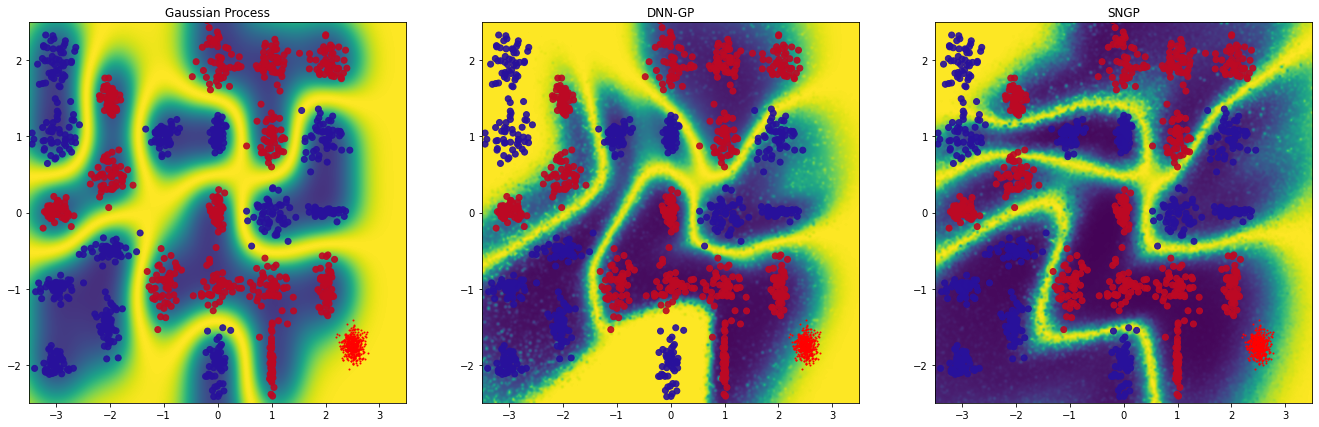

In [ ]:
# this function may failed. Simply run it again if it does.
def generate_25_gaussian():

    examples, labels = [], []

    c1 = (-1, -1), (-1, 1), (-3, 2), (-3, 1), (-3, 0), (-3, -1), (-3, -2), (-2, 1.5), (-2, 0.5)
    c2 = (-2, -0.5), (-2, -1.5), (0, 3), (0, 2), (0, 1), (0, 0), (0, -1), (0, -2), (0, -3)
    c3 = (1, 2), (1, 1), (1, 0), (1, -1), (1, -2), (2, 2), (2, 1), (2, 0), (2, -1)

    centroids = c1 + c2 + c3

    g1 = [1, 0, 0, 0, 1, 0, 0, 1, 1]
    g2 = [0, 0, 1, 1, 0, 1, 1, 0, 0]
    g3 = [1, 1, 0, 1, 1, 1, 0, 0, 1]

    ground_truth = g1 + g2 + g3

    size = 50
    for centroid, label in zip(centroids, ground_truth):
        cov  = np.random.rand(2)/20
        pts = np.random.multivariate_normal(
            centroid,
            np.diag(cov),
            size=size
        )
        examples.append(pts)
        labels.extend([label]*size)

    # generate data
    examples = np.concatenate(examples)
    labels = np.array(labels)

    # shuffle
    mask = np.arange(len(labels))
    np.random.shuffle(mask)
    examples = examples[mask]
    labels = labels[mask]

    dataset = torch.utils.data.TensorDataset(
        torch.Tensor(examples),
        torch.Tensor(labels).long()
    )

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


    while True:
        try:
            # this function can randomly due to this error
            # torch.linalg.cholesky: The factorization could not be completed because the input is not positive-definite'
            # simply try again
            prob_dnn_gp = question_4_dnn_gp(data_loader, with_spectral_normalization=False, lr=1e-3)
            break
        except:
            continue

    while True:
        try:
            prob_dnn_sngp = question_4_dnn_gp(data_loader, with_spectral_normalization=True, lr=1e-3)
            break
        except:
            continue
    prob_gp = question_4_gp(examples, labels)

    plt.figure(figsize=(23, 7))
    plt.subplot(1, 3, 1)
    plt.title("Gaussian Process")
    plot_result(examples, labels, prob_gp*(1 - prob_gp))

    plt.subplot(1, 3, 2)
    plt.title("DNN-GP")
    plot_result(examples, labels, prob_dnn_gp*(1 - prob_dnn_gp))

    plt.subplot(1, 3, 3)
    plt.title("SNGP")
    plot_result(examples, labels, prob_dnn_sngp*(1 - prob_dnn_sngp))


generate_25_gaussian()